## Access TROPOMI NO2 files using user i/p time&location using an API calls and extarct data via OPeNDAP server  

**Earthdata API is used to access and query NASA data, for details: https://pypi.org/project/earthdata/**

**To access the NASA satellite data, firstly we need to register ourselves on https://urs.earthdata.nasa.gov/, and create a username and password**

In [1]:
import earthdata ###API to access files from NASA earthdata directory
from earthdata import Auth, Store, DataCollections, DataGranules ###API to access files from NASA earthdata directory
import netCDF4 as nc4
from netCDF4 import Dataset
import numpy as np
import pandas as pd
from getpass import getpass  ### library to hide and encrypt password
from pydap.client import open_url ### to access OPeNDAP server
from pydap.cas.urs import setup_session  ### to access OPeNDAP server

**Authentication for accessing the files from NASA GESDISC DATA ARCHIVE *(done by accessing netric file)***

In [2]:
%%time
### Now we have to create a .netrc file in home directory using NASA earthdata-Username and Password
    ##cd ~ or cd $HOME
    ##touch .netrc
    ##echo "machine urs.earthdata.nasa.gov login <uid> password <password>" >> .netrc (where <uid> is your user name and <password> is your Earthdata Login password without the brackets)
    ##chmod 0600 .netrc (so only you can access it)
    
###Please execute this cell once NASA earthdata registeration is done and .netric file is created
auth = Auth()
auth.login(strategy="netrc")
# are we authenticated?
print(auth.authenticated)

You're now authenticated with NASA Earthdata Login
True
CPU times: total: 46.9 ms
Wall time: 190 ms


Note that in most cases, applications are authorized when you first access them but if you even find some more difficulty in accesing the data please check *How To Pre-authorize an application: https://wiki.earthdata.nasa.gov/display/EL/How+To+Pre-authorize+an+application

**We can also now search for collections using a pythonic API client for CMR**

In [3]:
###Locate DAAC (in oue case it is GES-DAAC to access TROPOMI S5P_L2_NO2_ files)###
#Query = DataCollections().daac("GES-DAAC")

###Find collections in the mentioned DAAC###
#print(f'Collections found: {Query.hits()}')
#collections = Query.fields(['ShortName']).get(10)

###Find the data of interest from collection of science data from GES DAAC###
#collections[:]

## Please enter date from 2019-08-06 onwards till date

### Input start time of interest

In [4]:
start_time = input('Enter start time in format: YYYY-MM-DD \n')

Enter start time in format: YYYY-MM-DD 
2022-07-16


### Input end time of interest

In [5]:
end_time = input('Enter end time in format: YYYY-MM-DD \n')

Enter end time in format: YYYY-MM-DD 
2022-07-17


**To find Sentinel-5P TROPOMI Tropospheric NO2 1-Orbit L2 5.5km x 3.5km V1 (2019-08-06 to 2021-07-01) and V2 (2021-07-01-ongoing); short name : S5P_L2__NO2____HiR ; at GES DISC
granules for given dates and access their metadata using get() method**

In [6]:
%%time
### We build our query, note as TROPOMI data comes 1file per orbit so we can temporally and spatially query the data### 
###spatial query : OTTAWA- -77.816162,44.474779,-73.937989,45.968509### -140,41,-50,56
###Please enter the location coordinates in bounding_box() in sequence: 'lower_left_lon', 'lower_left_lat', 'upper_right_lon', and 'upper_right_lat' 
###The short name for collection was found from cell[2] or from earthdata search###

from pprint import pprint
#Query = DataGranules().short_name('S5P_L2__NO2____HiR').bounding_box(-103,48,-101,49).temporal(start_time,end_time)

Query = DataGranules().short_name('S5P_L2__NO2____HiR').bounding_box(-140,0,-50,0).temporal(start_time,end_time)

###We get all metadata records###
granules = Query.get()

#granules

CPU times: total: 62.5 ms
Wall time: 433 ms


**Please note that Sentinel-5P TROPOMI Tropospheric NO2 1-Orbit L2 7km x 3.5km V1(S5P_L2__NO2___) at GES DIS 
starting from 2018-04-30 till 2019-08-06 can be accessed similarly using short name 'S5P_L2__NO2___' in the above code**

In [7]:
%%time
##length of spatiallly and temporally queried S5P_NO2 data

len(granules)

CPU times: total: 0 ns
Wall time: 0 ns


4

In [8]:
%%time
###a check just for verification: total number of files just temporally queried S5P_NO2 data (no spatial query inputed)

from pprint import pprint
Query = DataGranules().short_name('S5P_L2__NO2____HiR').temporal(start_time,end_time)

###We get all metadata records###
granules_1 = Query.get()

len(granules_1)

##note that the len(granule_1) is way more than len(granules) hence we are able to sort the tropomi data spatially and temorally

CPU times: total: 31.2 ms
Wall time: 695 ms


15

In [9]:
###explore granules metadata###
#[display(granule) for granule in granules]

**Now lets try to extract data URLS from the metadata of each datasets of our interest**

In [10]:
%%time
data_links = [granule.data_links() for granule in granules]

print(data_links)
#type(data_links)

[['https://data.gesdisc.earthdata.nasa.gov/data/S5P_TROPOMI_Level2/S5P_L2__NO2____HiR.2/2022/197/S5P_OFFL_L2__NO2____20220716T163804_20220716T181934_24648_02_020301_20220718T083126.nc', 's3://gesdisc-cumulus-prod-protected/S5P_TROPOMI_Level2/S5P_L2__NO2____HiR.2/2022/197/S5P_OFFL_L2__NO2____20220716T163804_20220716T181934_24648_02_020301_20220718T083126.nc'], ['https://data.gesdisc.earthdata.nasa.gov/data/S5P_TROPOMI_Level2/S5P_L2__NO2____HiR.2/2022/197/S5P_OFFL_L2__NO2____20220716T181934_20220716T200104_24649_02_020301_20220718T102129.nc', 's3://gesdisc-cumulus-prod-protected/S5P_TROPOMI_Level2/S5P_L2__NO2____HiR.2/2022/197/S5P_OFFL_L2__NO2____20220716T181934_20220716T200104_24649_02_020301_20220718T102129.nc'], ['https://data.gesdisc.earthdata.nasa.gov/data/S5P_TROPOMI_Level2/S5P_L2__NO2____HiR.2/2022/197/S5P_OFFL_L2__NO2____20220716T200104_20220716T214233_24650_02_020301_20220718T120645.nc', 's3://gesdisc-cumulus-prod-protected/S5P_TROPOMI_Level2/S5P_L2__NO2____HiR.2/2022/197/S5P_OF

**OOPS!! we are not able to access the NASA GESDISC DATA ARCHIVE server to directly download the files using get() method from earthdata library so lets take a long cut (atleast for time being)**

**'https' url for GES-DAAC server and 's3'for AWS are sorted...**

In [11]:
%%time
##covert list to dataframe .. a long cut again :)
import pandas as pd
df = pd.DataFrame(data_links, columns = ['https' , 'sf3'])

##converted dataframe back to list sorting https urls
inprem = df['https']#.values.tolist()
print(inprem)
type(inprem)

0    https://data.gesdisc.earthdata.nasa.gov/data/S...
1    https://data.gesdisc.earthdata.nasa.gov/data/S...
2    https://data.gesdisc.earthdata.nasa.gov/data/S...
3    https://data.gesdisc.earthdata.nasa.gov/data/S...
Name: https, dtype: object
CPU times: total: 0 ns
Wall time: 1.99 ms


pandas.core.series.Series

**Now,we have https urls for GHRC-DAAC server so we can either download the temporaly&spatially sorted datafiles(by uncommenting below cell) BUT we would try to extract data directly from OPeNDAP server using this links ;)**

***PLEASE NOTE: Extracting data directly from OPeNDAP server would save our PC memory as 1file ~ 600MB size (TROPOMI files are very heavy in data due to its higher resolution...)***

In [12]:
##Works https url opens and data is downloaded to downloads as default location
#url_list = ['https://data.gesdisc.earthdata.nasa.gov/data/S5P_TROPOMI_Level2/S5P_L2__NO2____HiR.1/2021/060/S5P_OFFL_L2__NO2____20210301T232825_20210302T010956_17530_01_010400_20210303T163111.nc', 'https://data.gesdisc.earthdata.nasa.gov/data/S5P_TROPOMI_Level2/S5P_L2__NO2____HiR.1/2021/113/S5P_OFFL_L2__NO2____20210423T014106_20210423T032236_18269_01_010400_20210424T183027.nc']

#import webbrowser
#for url in inprem:
 #   response = webbrowser.open(url)

In [13]:
%%time
substring = 'https://data.gesdisc.earthdata.nasa.gov/data/'
inprem_1 = inprem.str.replace(substring,"")
inprem_opendap = 'https://tropomi.gesdisc.eosdis.nasa.gov/opendap/' + inprem_1 #+ '.html'
inprem_opendap = inprem_opendap.values.tolist()
inprem_opendap
#type(inprem_opendap)
#inprem_opendap.iloc[0]

CPU times: total: 594 ms
Wall time: 986 ms


<timed exec>:2: FutureWarning: The default value of regex will change from True to False in a future version.


['https://tropomi.gesdisc.eosdis.nasa.gov/opendap/S5P_TROPOMI_Level2/S5P_L2__NO2____HiR.2/2022/197/S5P_OFFL_L2__NO2____20220716T163804_20220716T181934_24648_02_020301_20220718T083126.nc',
 'https://tropomi.gesdisc.eosdis.nasa.gov/opendap/S5P_TROPOMI_Level2/S5P_L2__NO2____HiR.2/2022/197/S5P_OFFL_L2__NO2____20220716T181934_20220716T200104_24649_02_020301_20220718T102129.nc',
 'https://tropomi.gesdisc.eosdis.nasa.gov/opendap/S5P_TROPOMI_Level2/S5P_L2__NO2____HiR.2/2022/197/S5P_OFFL_L2__NO2____20220716T200104_20220716T214233_24650_02_020301_20220718T120645.nc',
 'https://tropomi.gesdisc.eosdis.nasa.gov/opendap/S5P_TROPOMI_Level2/S5P_L2__NO2____HiR.2/2022/197/S5P_OFFL_L2__NO2____20220716T214233_20220716T232403_24651_02_020301_20220718T132425.nc']

**Now as we have the links lets connect to OPeNDAP server and extract tropospheric NOx data without actually downloading datafiles**

**PLEASE NOTE that the attempts to LOOP files>connect to OPeNDAP server>extarct&merge data, work is in progress ,
For now we will do it by manually accessing both files**

**Here we have read the file number 1 with detail explanation of procedures followed and the file number 2,3,4 are read with same logic but not descriptions**

In [14]:
%%time
###Read nc_file using OPeNDAP server directly
opendap_url = 'https://tropomi.gesdisc.eosdis.nasa.gov/opendap/S5P_TROPOMI_Level2/S5P_L2__NO2____HiR.2/2022/197/S5P_OFFL_L2__NO2____20220716T163804_20220716T181934_24648_02_020301_20220718T083126.nc'
###Please enter your own NASA earthdata login Username and Password
username = 'XXXXX' ###Add your Username here
password = getpass('PLease enter your NASA earthdata login Password: ')

session = setup_session(username, password, check_url=opendap_url)

dataset = open_url(opendap_url, session=session)

PLease enter your NASA earthdata login Password: ········
CPU times: total: 719 ms
Wall time: 29.4 s


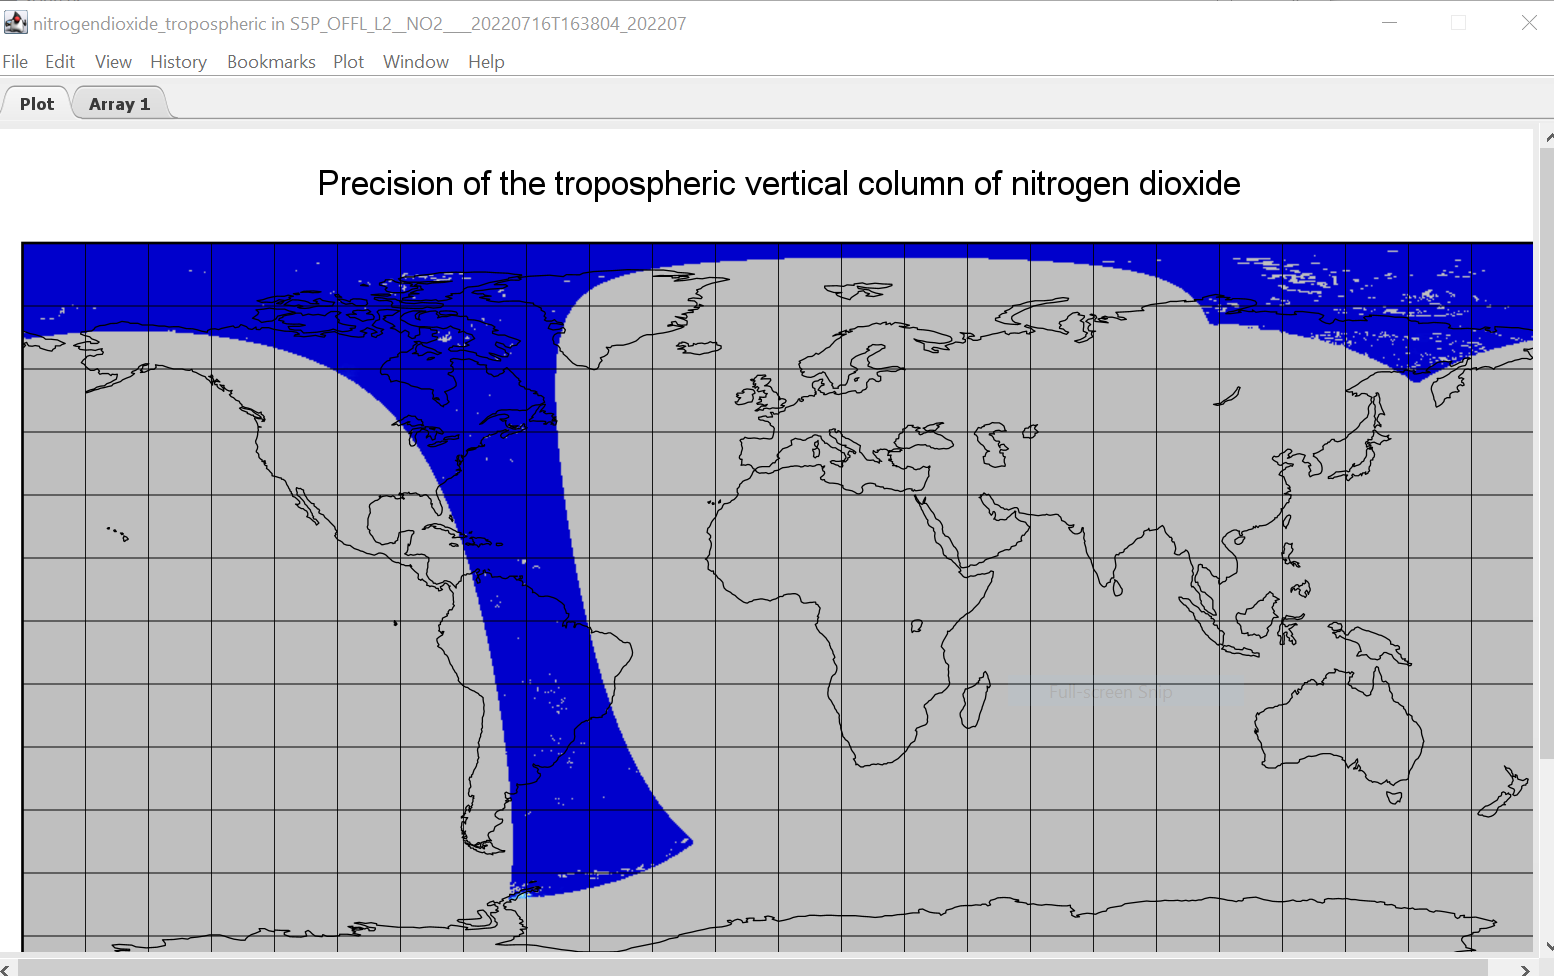

In [15]:
%%time
### array data extracted from netcdf4 saved in variable

lats = dataset['PRODUCT_latitude'][:][0,2086:4172,:] ##note the reading of variable is bit different in case of opendap file
lons = dataset['PRODUCT_longitude'][:][0,2086:4172,:]
no2 = dataset['PRODUCT_nitrogendioxide_tropospheric_column_precision'][:][0,2086:4172,:]
qa_value = dataset['PRODUCT_qa_value'][0,2086:4172,:]
delta_time = dataset['PRODUCT_delta_time'][0,2086:4172]

print (delta_time.shape)
print (lons.shape)
print (lats.shape)
print (no2.shape)
print (qa_value.shape)

(1, 2086)
(2086, 450)
(2086, 450)
(2086, 450)
(1, 2086, 450)
CPU times: total: 641 ms
Wall time: 32 s


In [16]:
%%time
### seconds time to datetime

##delta_time given in seconds is relative to start time in this case start time is 'milliseconds since 2022-07-16 00:00:00'

from netCDF4 import Dataset, num2date
import numpy as np
from datetime import datetime as d
import numpy.ma as ma

no2_time = num2date(delta_time[:], 'milliseconds since 2022-07-16 00:00:00').ravel() 
## auto add start time , ravel helps to remove extra square bracket ie covert 2d to 1d (as shape of delta_time is 1,4172)  

no2_delta_time = [d.strftime('%Y-%m-%d %H:%M:%S %z') for d in no2_time]
#no2_delta_time

CPU times: total: 93.8 ms
Wall time: 72.8 ms


In [17]:
%%time
### delta_time from list to dataframe

no2_delta_time = pd.DataFrame(no2_delta_time,columns=['no2_delta_time'])
### As time is same for a given across_length which is 450 so we replicate each row by 450 
no2_delta_time = pd.concat([no2_delta_time]*450).sort_index()
no2_delta_time = no2_delta_time.rename_axis('along_index').reset_index()
no2_delta_time = no2_delta_time['no2_delta_time']
no2_delta_time

CPU times: total: 172 ms
Wall time: 144 ms


0         2022-07-16 17:28:51 -0400
1         2022-07-16 17:28:51 -0400
2         2022-07-16 17:28:51 -0400
3         2022-07-16 17:28:51 -0400
4         2022-07-16 17:28:51 -0400
                    ...            
938695    2022-07-16 17:58:02 -0400
938696    2022-07-16 17:58:02 -0400
938697    2022-07-16 17:58:02 -0400
938698    2022-07-16 17:58:02 -0400
938699    2022-07-16 17:58:02 -0400
Name: no2_delta_time, Length: 938700, dtype: object

In [18]:
%%time
### no2 latitude from masked array to dataframe

lats_pd = pd.DataFrame(lats)
lats_pd = lats_pd.stack().reset_index()  ##stack() helps to convert 450 columns of accross track into a single column
lats_pd.columns = ['along_index','across_index', 'lat']

##lats_pd = lats_pd[lats_pd.columns[lats_pd.max() > 0]] 
#lats_pd

CPU times: total: 46.9 ms
Wall time: 54.9 ms


In [19]:
%%time
### no2 longitude from masked array to dataframe

lons_pd = pd.DataFrame(lons).T
lons_pd = lons_pd.stack().reset_index()
lons_pd.columns = ['along_index', 'across_index', 'lon']
lons_pd = lons_pd['lon']
#lons_pd

CPU times: total: 46.9 ms
Wall time: 45.4 ms


In [20]:
%%time
### no2 tropospheric value from masked array to dataframe

no2_pd = pd.DataFrame(no2).T
no2_pd = no2_pd.stack(dropna=False).reset_index()
no2_pd.columns = ['along_index', 'across_index', 'no2_val']
no2_pd = no2_pd['no2_val']
#no2_pd

CPU times: total: 46.9 ms
Wall time: 52.9 ms


In [21]:
%%time
### no2 qa_value ie data quality value from masked array to dataframe

qa_val_pd = pd.DataFrame(qa_value.reshape(1,-1)).T
qa_val_pd.columns = ['qa_val']
#qa_val_pd

CPU times: total: 125 ms
Wall time: 132 ms


In [22]:
%%time
### merge all dataframes 

tropomi_pd = pd.concat([lats_pd,lons_pd,no2_delta_time,no2_pd,qa_val_pd],axis=1) #,no2_pd,qa_val_pd)
#tropomi_pd

CPU times: total: 31.2 ms
Wall time: 28 ms


In [23]:
%%time
### spatially query no2 data (canada region)

#tropomi_pd_nona = tropomi_pd.dropna()
tropomi_pd_filtered = tropomi_pd.query('-140 <= lon <= -50 and 41 < lat <= 56')
tp_no2_1 = tropomi_pd_filtered#.reset_index().round(decimals=6)
tp_no2_1=tp_no2_1.loc[:,['along_index','across_index','lat','lon','no2_delta_time','no2_val','qa_val']]
tp_no2_1

CPU times: total: 62.5 ms
Wall time: 69.8 ms


,along_index,across_index,lat,lon,no2_delta_time,no2_val,qa_val
139855,310,355,41.000668,-71.981293,2022-07-16 17:33:11 -0400,0.000007,100
139856,310,356,41.004734,-71.997704,2022-07-16 17:33:11 -0400,0.000007,100
139857,310,357,41.008751,-72.014259,2022-07-16 17:33:11 -0400,0.000007,100
139858,310,358,41.012726,-72.030792,2022-07-16 17:33:11 -0400,0.000007,100
139859,310,359,41.016647,-72.047333,2022-07-16 17:33:11 -0400,0.000006,100
...,...,...,...,...,...,...,...
937591,2083,241,50.680164,-50.118195,2022-07-16 17:58:00 -0400,0.000004,0
937592,2083,242,50.689362,-50.093967,2022-07-16 17:58:00 -0400,0.000004,0
937593,2083,243,50.698574,-50.069405,2022-07-16 17:58:00 -0400,0.000004,0
937594,2083,244,50.707790,-50.044598,2022-07-16 17:58:00 -0400,0.000004,0


**Similarly all the other 3 TROPOMI NO2 files are read using same logic and at last all the dataframes are merged together into a single dataframe**

READ 2nd TROPOMI file > using the second URL from cell [13] 

In [24]:
%%time
###Read nc_file using OPeNDAP server directly
opendap_url = 'https://tropomi.gesdisc.eosdis.nasa.gov/opendap/S5P_TROPOMI_Level2/S5P_L2__NO2____HiR.2/2022/197/S5P_OFFL_L2__NO2____20220716T181934_20220716T200104_24649_02_020301_20220718T102129.nc'
###Please enter your own NASA earthdata login Username and Password
#username = 'adi205'
#password = getpass('PLease enter your NASA earthdata login Password: ')

session = setup_session(username, password, check_url=opendap_url)

dataset = open_url(opendap_url, session=session)

CPU times: total: 719 ms
Wall time: 24.2 s


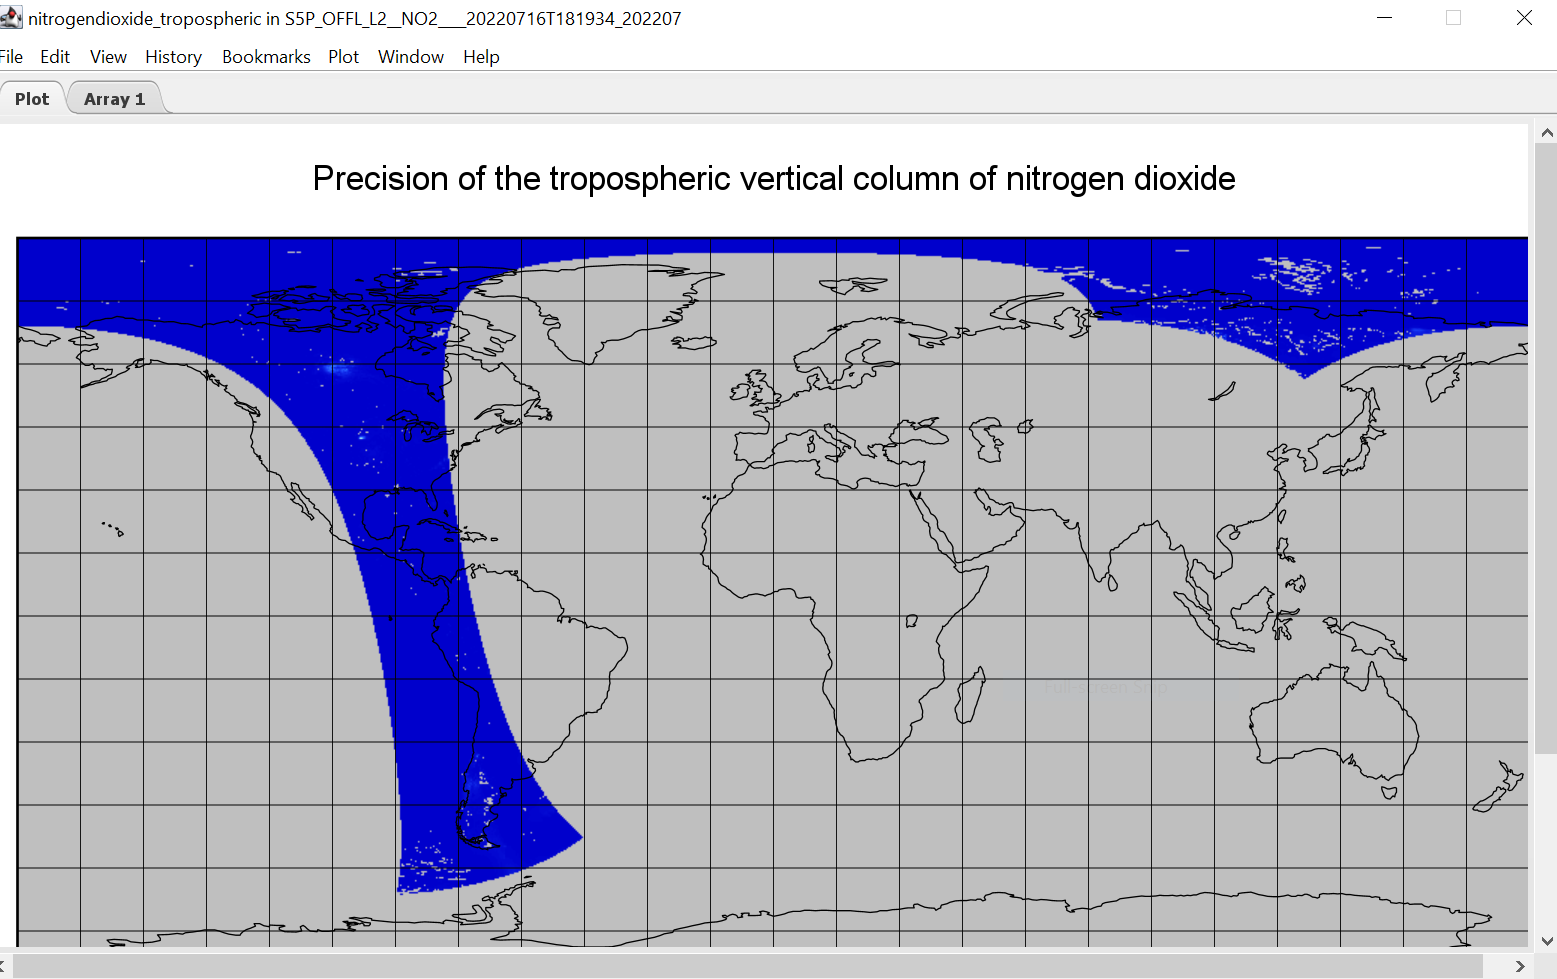

In [25]:
%%time
lats = dataset['PRODUCT_latitude'][:][0,2086:4172,:] ##note the reading of variable is bit different in case of opendap file
lons = dataset['PRODUCT_longitude'][:][0,2086:4172,:]
no2 = dataset['PRODUCT_nitrogendioxide_tropospheric_column_precision'][:][0,2086:4172,:]
qa_value = dataset['PRODUCT_qa_value'][0,2086:4172,:]
delta_time = dataset['PRODUCT_delta_time'][0,2086:4172]

CPU times: total: 578 ms
Wall time: 28.8 s


In [26]:
%%time
no2_time = num2date(delta_time[:], 'milliseconds since 2022-07-16 00:00:00').ravel() 
no2_delta_time = [d.strftime('%Y-%m-%d %H:%M:%S %z') for d in no2_time]
no2_delta_time = pd.DataFrame(no2_delta_time,columns=['no2_delta_time'])
no2_delta_time = pd.concat([no2_delta_time]*450).sort_index()
no2_delta_time = no2_delta_time.rename_axis('along_index').reset_index()
no2_delta_time = no2_delta_time['no2_delta_time']

lats_pd = pd.DataFrame(lats)
lats_pd = lats_pd.stack().reset_index()  
lats_pd.columns = ['along_index','across_index', 'lat']

lons_pd = pd.DataFrame(lons)
lons_pd = lons_pd.stack().reset_index()
lons_pd.columns = ['along_index', 'across_index', 'lon']
lons_pd = lons_pd['lon']

no2_pd = pd.DataFrame(no2)
no2_pd = no2_pd.stack(dropna=False).reset_index()
no2_pd.columns = ['along_index', 'across_index', 'no2_val']
no2_pd = no2_pd['no2_val']

qa_val_pd = pd.DataFrame(qa_value.reshape(1,-1)).T
qa_val_pd.columns = ['qa_val']

CPU times: total: 422 ms
Wall time: 419 ms


In [27]:
%%time
tropomi_pd = pd.concat([lats_pd,lons_pd,no2_delta_time,no2_pd,qa_val_pd],axis=1) ### merge all dataframes 
tropomi_pd_filtered_2 = tropomi_pd.query('-140 <= lon <= -50 and 41 < lat <= 56')### spatially query no2 data (canada region)
tp_no2_2 = tropomi_pd_filtered_2.reset_index().round(decimals=6)
tp_no2_2=tp_no2_2.loc[:,['along_index','across_index','lat','lon','no2_delta_time','no2_val','qa_val']]
tp_no2_2 

CPU times: total: 109 ms
Wall time: 97 ms


C:\ProgramData\Anaconda3\envs\GEODACenv\lib\site-packages\pandas\core\series.py:2442: RuntimeWarning: overflow encountered in multiply
  result = self._values.round(decimals)


,along_index,across_index,lat,lon,no2_delta_time,no2_val,qa_val
0,308,382,41.001007,-85.157356,2022-07-16 19:14:39 -0400,0.000015,74
1,308,383,41.003437,-85.072037,2022-07-16 19:14:39 -0400,0.000018,74
2,308,384,41.005783,-84.985794,2022-07-16 19:14:39 -0400,0.000027,74
3,308,385,41.008045,-84.898621,2022-07-16 19:14:39 -0400,0.000013,74
4,308,386,41.010220,-84.810486,2022-07-16 19:14:39 -0400,0.000014,74
...,...,...,...,...,...,...,...
141788,788,0,55.884174,-125.212341,2022-07-16 19:21:23 -0400,inf,0
141789,788,1,55.946316,-125.107910,2022-07-16 19:21:23 -0400,0.000008,74
141790,789,0,55.923439,-125.268539,2022-07-16 19:21:23 -0400,inf,0
141791,789,1,55.985638,-125.164101,2022-07-16 19:21:23 -0400,0.000008,74


In [28]:
%%time
###Read nc_file using OPeNDAP server directly
opendap_url = 'https://tropomi.gesdisc.eosdis.nasa.gov/opendap/S5P_TROPOMI_Level2/S5P_L2__NO2____HiR.2/2022/197/S5P_OFFL_L2__NO2____20220716T200104_20220716T214233_24650_02_020301_20220718T120645.nc'
###Please enter your own NASA earthdata login Username and Password
#username = 'adi205'
#password = getpass('PLease enter your NASA earthdata login Password: ')

session = setup_session(username, password, check_url=opendap_url)

dataset = open_url(opendap_url, session=session)

CPU times: total: 781 ms
Wall time: 24.4 s


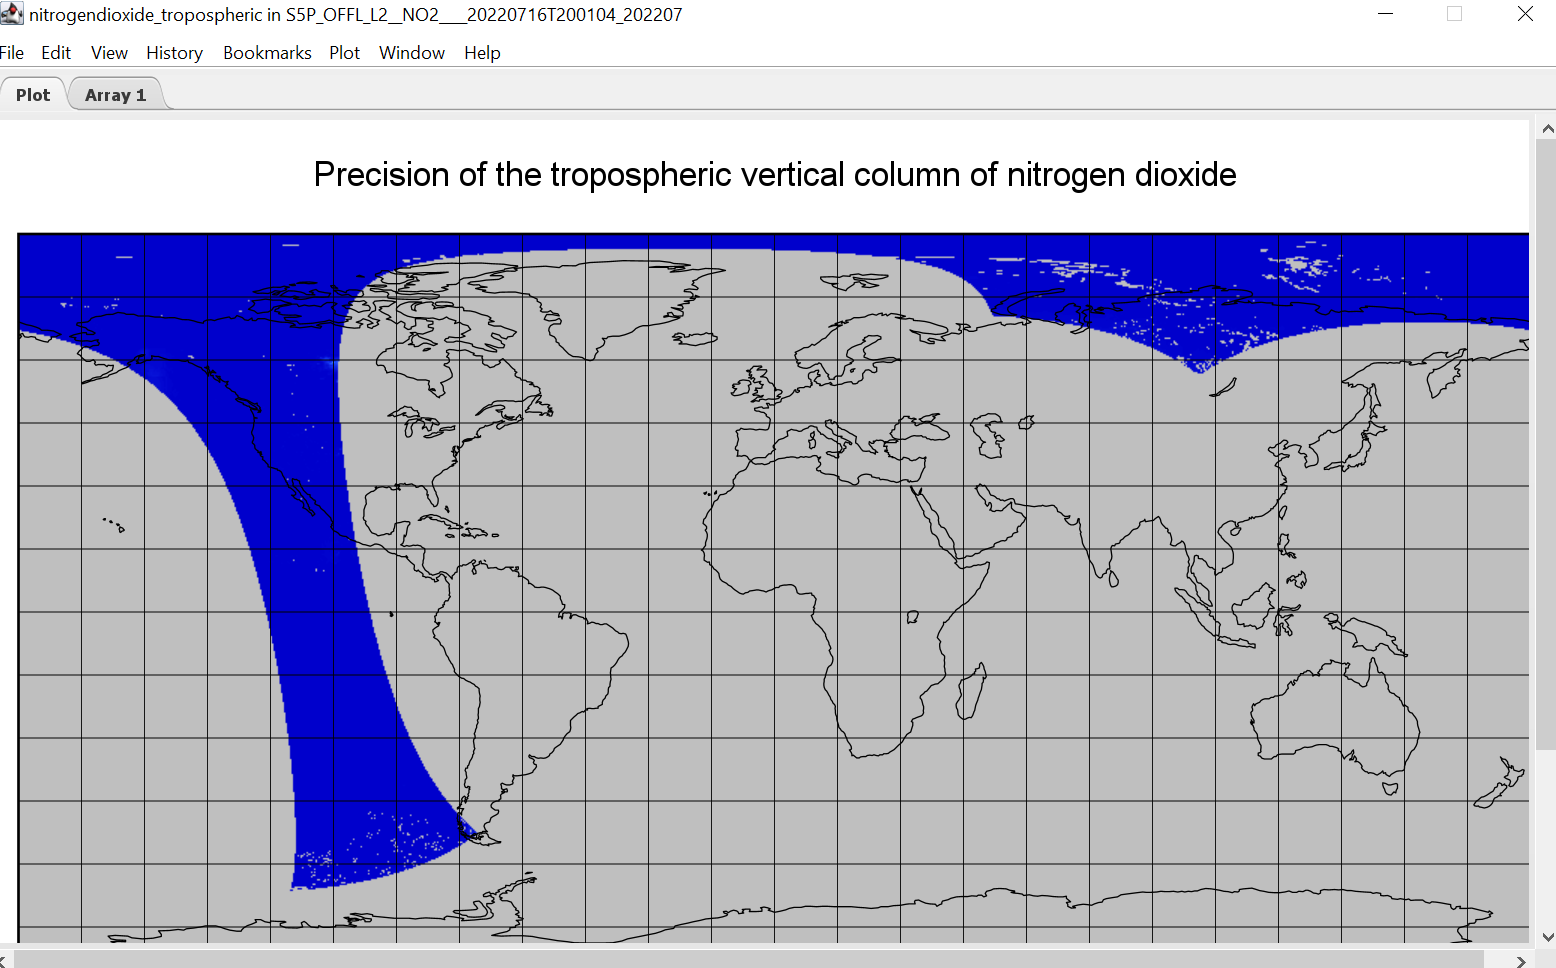

In [29]:
%%time
lats = dataset['PRODUCT_latitude'][:][0,2086:4172,:] ##note the reading of variable is bit different in case of opendap file
lons = dataset['PRODUCT_longitude'][:][0,2086:4172,:]
no2 = dataset['PRODUCT_nitrogendioxide_tropospheric_column_precision'][:][0,2086:4172,:]
qa_value = dataset['PRODUCT_qa_value'][0,2086:4172,:]
delta_time = dataset['PRODUCT_delta_time'][0,2086:4172]

CPU times: total: 703 ms
Wall time: 28.8 s


In [30]:
%%time
no2_time = num2date(delta_time[:], 'milliseconds since 2022-07-16 00:00:00').ravel() 
no2_delta_time = [d.strftime('%Y-%m-%d %H:%M:%S %z') for d in no2_time]
no2_delta_time = pd.DataFrame(no2_delta_time,columns=['no2_delta_time'])
no2_delta_time = pd.concat([no2_delta_time]*450).sort_index()
no2_delta_time = no2_delta_time.rename_axis('along_index').reset_index()
no2_delta_time = no2_delta_time['no2_delta_time']

lats_pd = pd.DataFrame(lats)
lats_pd = lats_pd.stack().reset_index()  
lats_pd.columns = ['along_index','across_index', 'lat']

lons_pd = pd.DataFrame(lons).T
lons_pd = lons_pd.stack().reset_index()
lons_pd.columns = ['along_index', 'across_index', 'lon']
lons_pd = lons_pd['lon']

no2_pd = pd.DataFrame(no2).T
no2_pd = no2_pd.stack(dropna=False).reset_index()
no2_pd.columns = ['along_index', 'across_index', 'no2_val']
no2_pd = no2_pd['no2_val']

qa_val_pd = pd.DataFrame(qa_value.reshape(1,-1)).T
qa_val_pd.columns = ['qa_val']

CPU times: total: 531 ms
Wall time: 586 ms


In [31]:
%%time
tropomi_pd = pd.concat([lats_pd,lons_pd,no2_delta_time,no2_pd,qa_val_pd],axis=1)### merge all dataframes 
tropomi_pd_filtered_3 = tropomi_pd.query('-140 <= lon <= -50 and 41 < lat <= 56')### spatially query no2 data (canada region)
tp_no2_3 = tropomi_pd_filtered_3.reset_index().round(decimals=6)
tp_no2_3=tp_no2_3.loc[:,['along_index','across_index','lat','lon','no2_delta_time','no2_val','qa_val']]
tp_no2_3

CPU times: total: 125 ms
Wall time: 97 ms


C:\ProgramData\Anaconda3\envs\GEODACenv\lib\site-packages\pandas\core\series.py:2442: RuntimeWarning: overflow encountered in multiply
  result = self._values.round(decimals)


,along_index,across_index,lat,lon,no2_delta_time,no2_val,qa_val
0,310,353,41.003284,-122.696030,2022-07-16 20:56:11 -0400,0.000005,100
1,310,354,41.007439,-122.712456,2022-07-16 20:56:11 -0400,0.000005,74
2,310,355,41.011547,-122.728958,2022-07-16 20:56:11 -0400,0.000005,74
3,310,356,41.015610,-122.745422,2022-07-16 20:56:11 -0400,0.000005,100
4,310,357,41.019627,-122.761909,2022-07-16 20:56:11 -0400,0.000005,100
...,...,...,...,...,...,...,...
88319,2084,104,49.233540,-52.607151,2022-07-16 21:21:01 -0400,0.000006,0
88320,2084,105,49.246712,-51.983761,2022-07-16 21:21:01 -0400,0.000006,0
88321,2084,106,49.259789,-51.352425,2022-07-16 21:21:01 -0400,0.000006,0
88322,2084,107,49.272766,-50.713566,2022-07-16 21:21:01 -0400,0.000006,0


In [32]:
%%time
###Read nc_file using OPeNDAP server directly
opendap_url = 'https://tropomi.gesdisc.eosdis.nasa.gov/opendap/S5P_TROPOMI_Level2/S5P_L2__NO2____HiR.2/2022/197/S5P_OFFL_L2__NO2____20220716T214233_20220716T232403_24651_02_020301_20220718T132425.nc'
###Please enter your own NASA earthdata login Username and Password
#username = 'adi205'
#password = getpass('PLease enter your NASA earthdata login Password: ')

session = setup_session(username, password, check_url=opendap_url)

dataset = open_url(opendap_url, session=session)

CPU times: total: 859 ms
Wall time: 24.7 s


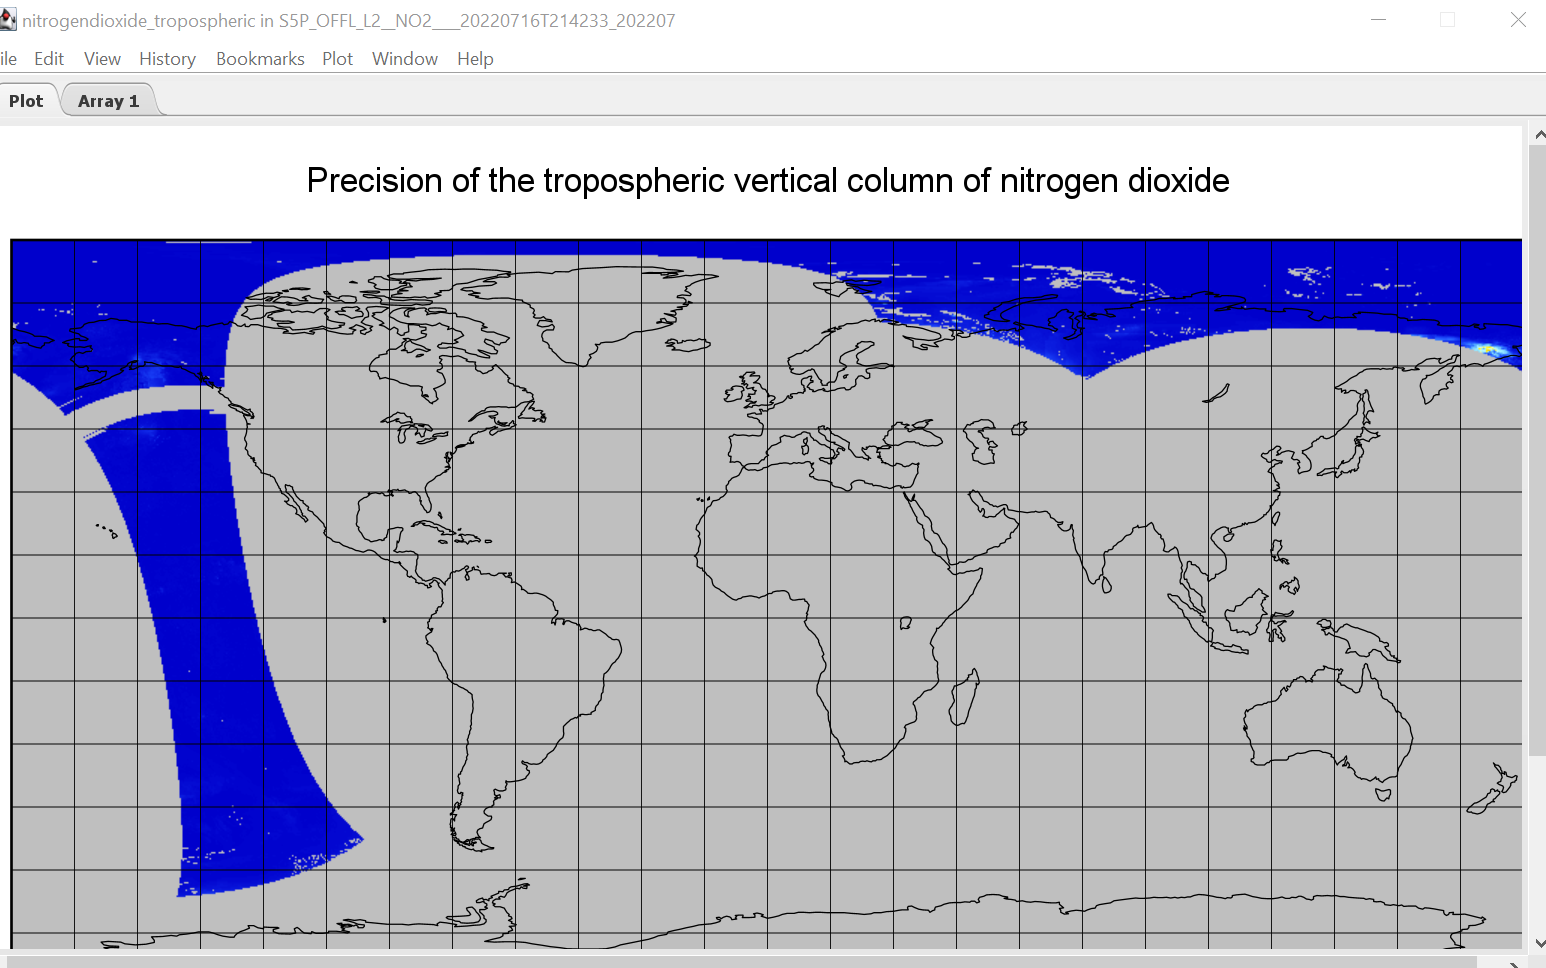

In [33]:
%%time
lats = dataset['PRODUCT_latitude'][:][0,2086:4172,:] ##note the reading of variable is bit different in case of opendap file
lons = dataset['PRODUCT_longitude'][:][0,2086:4172,:]
no2 = dataset['PRODUCT_nitrogendioxide_tropospheric_column_precision'][:][0,2086:4172,:]
qa_value = dataset['PRODUCT_qa_value'][0,2086:4172,:]
delta_time = dataset['PRODUCT_delta_time'][0,2086:4172]

CPU times: total: 969 ms
Wall time: 35.9 s


In [34]:
%%time
no2_time = num2date(delta_time[:], 'milliseconds since 2022-07-16 00:00:00').ravel() 
no2_delta_time = [d.strftime('%Y-%m-%d %H:%M:%S %z') for d in no2_time]
no2_delta_time = pd.DataFrame(no2_delta_time,columns=['no2_delta_time'])
no2_delta_time = pd.concat([no2_delta_time]*450).sort_index()
no2_delta_time = no2_delta_time.rename_axis('along_index').reset_index()
no2_delta_time = no2_delta_time['no2_delta_time']

lats_pd = pd.DataFrame(lats)
lats_pd = lats_pd.stack().reset_index()  
lats_pd.columns = ['along_index','across_index', 'lat']

lons_pd = pd.DataFrame(lons).T
lons_pd = lons_pd.stack().reset_index()
lons_pd.columns = ['along_index', 'across_index', 'lon']
lons_pd = lons_pd['lon']

no2_pd = pd.DataFrame(no2).T
no2_pd = no2_pd.stack(dropna=False).reset_index()
no2_pd.columns = ['along_index', 'across_index', 'no2_val']
no2_pd = no2_pd['no2_val']

qa_val_pd = pd.DataFrame(qa_value.reshape(1,-1)).T
qa_val_pd.columns = ['qa_val']

CPU times: total: 453 ms
Wall time: 446 ms


In [35]:
%%time
tropomi_pd = pd.concat([lats_pd,lons_pd,no2_delta_time,no2_pd,qa_val_pd],axis=1)### merge all dataframes 
tropomi_pd_filtered_4 = tropomi_pd.query('-140 <= lon <= -50 and 41 < lat <= 56')### spatially query no2 data (canada region)
tp_no2_4 = tropomi_pd_filtered_4.rename_axis('index').reset_index().round(decimals=6)
tp_no2_4=tp_no2_4.loc[:,['along_index','across_index','lat','lon','no2_delta_time','no2_val','qa_val']]
tp_no2_4

CPU times: total: 62.5 ms
Wall time: 80.8 ms


C:\ProgramData\Anaconda3\envs\GEODACenv\lib\site-packages\pandas\core\series.py:2442: RuntimeWarning: overflow encountered in multiply
  result = self._values.round(decimals)


,along_index,across_index,lat,lon,no2_delta_time,no2_val,qa_val
0,1725,0,55.881351,-133.295715,2022-07-16 22:59:28 -0400,0.000006,0
1,1725,1,55.924244,-133.304657,2022-07-16 22:59:28 -0400,0.000006,0
2,1725,2,55.966412,-133.313599,2022-07-16 22:59:28 -0400,0.000007,0
3,1726,0,55.841969,-138.978363,2022-07-16 22:59:29 -0400,0.000007,0
4,1726,1,55.884796,-138.989883,2022-07-16 22:59:29 -0400,0.000006,0
...,...,...,...,...,...,...,...
32489,1943,138,49.631554,-53.248207,2022-07-16 23:02:31 -0400,0.000006,0
32490,1943,139,49.642349,-52.452461,2022-07-16 23:02:31 -0400,0.000007,0
32491,1943,140,49.653099,-51.656254,2022-07-16 23:02:31 -0400,0.000006,0
32492,1943,141,49.663803,-50.859280,2022-07-16 23:02:31 -0400,0.000006,0


In [36]:
%%time
tp_no2 = pd.concat([tp_no2_1,tp_no2_2,tp_no2_3,tp_no2_4],axis=0)
tp_no2

CPU times: total: 15.6 ms
Wall time: 19 ms


,along_index,across_index,lat,lon,no2_delta_time,no2_val,qa_val
139855,310,355,41.000668,-71.981293,2022-07-16 17:33:11 -0400,0.000007,100
139856,310,356,41.004734,-71.997704,2022-07-16 17:33:11 -0400,0.000007,100
139857,310,357,41.008751,-72.014259,2022-07-16 17:33:11 -0400,0.000007,100
139858,310,358,41.012726,-72.030792,2022-07-16 17:33:11 -0400,0.000007,100
139859,310,359,41.016647,-72.047333,2022-07-16 17:33:11 -0400,0.000006,100
...,...,...,...,...,...,...,...
32489,1943,138,49.631554,-53.248207,2022-07-16 23:02:31 -0400,0.000006,0
32490,1943,139,49.642349,-52.452461,2022-07-16 23:02:31 -0400,0.000007,0
32491,1943,140,49.653099,-51.656254,2022-07-16 23:02:31 -0400,0.000006,0
32492,1943,141,49.663803,-50.859280,2022-07-16 23:02:31 -0400,0.000006,0


In [42]:
tp_no2.to_csv('tropomi_iss_july16to17_2022_full_v3.csv')

***THE CODE ENDs***

**Total time taken to RUN full code ~4 minutes**

**Maximum time of approx 50 to 55 secs (for each out of the 4 files) is spent on connecting to OPeNDAP server and extract the sliced data**,***for a given day (16-17th july 2022,region-canada)***

## Issues yet to be addressed